# One leg PIP model 🦿 🎐

## Burocrazia
La maggior parte di queste librerie servono per fare il video in Colab

In [1]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data as pd
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 7.2 MB/s eta 0:00:00


## Getting model 🦭 📡

In [2]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/1LegTrail/Giunto_versione_fascia_elastica

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 1306, done.
remote: Counting objects: 100% (749/749), done.
remote: Compressing objects: 100% (404/404), done.
remote: Total 1306 (delta 546), reused 477 (delta 343), pack-reused 557 (from 1)
Receiving objects: 100% (1306/1306), 13.45 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (859/859), done.
/content/Real_Mega_Fufi/Robot/1LegTrail/Giunto_versione_fascia_elastica


## Pybullet set up 🔖 📚 🐨

In [62]:
#connecting
p.connect(p.DIRECT)
# using FEM
p.resetSimulation(p.RESET_USE_DEFORMABLE_WORLD)
#set sampling time
p.setGravity(0, 0, -9.81)
# set sampling time: if too high it becomes instable
# Aggiungi il percorso dei dati PyBullet for the plane
p.setAdditionalSearchPath(pd.getDataPath())


## Importing objects and chaning visual shape 🏮 🍀

Importing plane and fix it on the ground

In [63]:
useFixedBase_flag = True
plane_pos = [0,0,0]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=useFixedBase_flag)

Importing joint. It's a .obj file, so be sure to look at the important note in this notebook [here](https://colab.research.google.com/github/Gaianeve/Real_Mega_Fufi/blob/main/Robot/1LegTrail/See_model.ipynb?hl=it#scrollTo=cY6oVd0Um4e_)

In [64]:
elastic_joint_id = p.loadSoftBody("elastic_joint.obj",
                                  mass=0.0569,
                                  useNeoHookean=1,
                                  NeoHookeanMu=76.92e9,
                                  NeoHookeanLambda=115.38e9,
                                  NeoHookeanDamping=0.1,
                                  collisionMargin=0.001,
                                  useSelfCollision=0
                                  )
#arancione
p.changeVisualShape(elastic_joint_id, -1, rgbaColor=[1, 0.65, 0, 1])

print(elastic_joint_id)
#print(p.getCollisionShapeData(elastic_joint_id, -1))

1


default function parameters


```
int bodyUniqueId = -1;
	const char* fileName = "";
	double scale = -1;
	double mass = -1;
	double collisionMargin = -1;
	int useMassSpring = 0;
	int useBendingSprings = 0;
	int useNeoHookean = 0;
	double springElasticStiffness = 1;
	double springDampingStiffness = 0.1;
	int springDampingAllDirections = 0;
	double springBendingStiffness = 0.1;
	double NeoHookeanMu = 1;
	double NeoHookeanLambda = 1;
	double NeoHookeanDamping = 0.1;
	double frictionCoeff = 0;
	int useFaceContact = 0;
	int useSelfCollision = 0;
	double repulsionStiffness = 0.5;
	const char* simFileName = "";

```



In [65]:
#p.addUserDebugLine([0,0,0], [0,0,3])
#p.addUserDebugLine([0,0,0], [0,3,0])
#p.addUserDebugLine([0,0,0], [3,0,0])

Importing column and leg. See the same notebook as before for details on positions.

In [66]:
#get column
joint_position, joint_orientation = p.getBasePositionAndOrientation(elastic_joint_id)
joint_x, joint_y = joint_position[0], joint_position[1]
column_position = [joint_x, joint_y, 0.1]
column_orientation = p.getQuaternionFromEuler([0,0,0])

column_id = p.loadURDF("pippa_oneleg_column.urdf", \
                       basePosition = column_position, \
                       baseOrientation =column_orientation , \
                       useFixedBase= useFixedBase_flag)
# verdino
p.changeVisualShape(column_id, -1, rgbaColor=[0.5, 1, 0.5, 1])

#get leg
leg_position = [joint_x,joint_y,0.6175]
leg_orientation = joint_orientation
leg_id = p.loadURDF("pippa_oneleg_leg.urdf", \
                       basePosition = leg_position, \
                       baseOrientation = leg_orientation,\
                       useFixedBase = False )
# azzurrino
p.changeVisualShape(leg_id, -1, rgbaColor=[0.5, 0.8, 1, 1])

##change materials

In [67]:
#AL 6082 (Alluminio)
lateralFriction_Al = 0.8
restitution_Al = 0
rollingFriction_Al = 0.001
spinningFriction_Al = 0.1
linearDamping_Al = 0.5
angularDamping_Al = 0.5
contactStiffness_Al = 3e8
contactDamping_Al = 100

# AISI 304 (Acciaio Inox)
lateralFriction_AISI = 0.8
restitution_AISI = 0
rollingFriction_AISI = 0.001
spinningFriction_AISI= 0.15
linearDamping_AISI = 0.5
angularDamping_AISI = 0.5
contactStiffness_AISI = 8e8
contactDamping_AISI = 100


# Al 6082

p.changeDynamics(leg_id,
                 -1,
                 lateralFriction=lateralFriction_Al,
                 restitution=restitution_Al,
                 spinningFriction= spinningFriction_Al,
                 rollingFriction= rollingFriction_Al,
                 linearDamping=linearDamping_Al,
                 angularDamping=angularDamping_Al,
                 contactStiffness = contactStiffness_Al,
                 contactDamping = contactDamping_Al
                 )
# AISI 304
p.changeDynamics(column_id,
                 -1,
                 lateralFriction=lateralFriction_AISI,
                 restitution=restitution_AISI,
                 spinningFriction= spinningFriction_AISI,
                 rollingFriction= rollingFriction_AISI,
                 linearDamping=linearDamping_AISI,
                 angularDamping=angularDamping_AISI,
                 contactStiffness = contactStiffness_AISI,
                 contactDamping = contactDamping_AISI
                 )


## Anchoring ⚓ 🦋
See same notebook for details and functions sintax. Keep in mind that these function are not well documented on pybullet start guide!

In [68]:
# Recupera le posizioni dei nodi del soft body
mesh_data = p.getMeshData(elastic_joint_id, flags=p.MESH_DATA_SIMULATION_MESH)
up = 0
down = 0

if mesh_data:
    num_nodes = mesh_data[0]  # Numero di nodi
    node_positions = mesh_data[1]  # Posizioni dei nodi

    # Identifica i limiti superiore e inferiore di z
    z_values = [pos[2] for pos in node_positions]
    max_z = max(z_values)
    min_z = min(z_values)
    tolerance = 0.0001  # Definisce una soglia di tolleranza

    # Ancoraggio dei nodi alle facce superiore e inferiore
    for node_index, node_pos in enumerate(node_positions):
        if abs(node_pos[2] - max_z) <= tolerance:
            # Nodo superiore: ancora alla gamba
            p.createSoftBodyAnchor(elastic_joint_id, node_index, leg_id, -1)
            up = up + 1
            #print("indice up:", node_index)
        elif abs(node_pos[2] - min_z) <= tolerance:
            # Nodo inferiore: ancora alla colonna
            p.createSoftBodyAnchor(elastic_joint_id, node_index, column_id, -1)
            down = down +1
            #print("indice down:", node_index)

else:
    print("Errore: I dati della mesh non sono stati recuperati correttamente.")

In [69]:
p.setPhysicsEngineParameter(
    fixedTimeStep=0.000008,    # Impostato per una simulazione più stabile
    numSolverIterations=500, # Aumentato per migliorare la convergenza
    numSubSteps=40,          # Aumentato per maggiore precisione
    solverResidualThreshold=1e-8,  # Precisione maggiore
    contactBreakingThreshold=0.0005, # Tolleranza delle collisioni ridotta
    enableConeFriction=1,          # Abilitato l'attrito conico per il comportamento realistico
    erp=0.8,                     # Parametro di riduzione degli errori (aumento della velocità di correzione)
    frictionERP=0.8,              # Parametro di attrito per i vincoli
    restitutionVelocityThreshold=0.1, # Velocità minima per il rimbalzo
    collisionFilterMode=0,        # Disabilita i filtri per le collisioni (se non necessari)
    enableFileCaching=1           # Abilita la cache dei file per velocizzare il caricamento
)


# Parametri di `setPhysicsEngineParameter()` in PyBullet

La funzione `setPhysicsEngineParameter()` consente di configurare i parametri del motore fisico in PyBullet. Di seguito una descrizione dei principali parametri.

---

## Principali Parametri

### 1. `fixedTimeStep`
- **Descrizione:** Imposta il timestep fisso utilizzato dal motore fisico.
- **Valori tipici:** `0.001` - `0.01` (in secondi).
- **Uso:** Controlla quanto spesso il motore fisico aggiorna lo stato della simulazione. Valori più piccoli migliorano la precisione, ma aumentano il costo computazionale.

---

### 2. `numSolverIterations`
- **Descrizione:** Numero di iterazioni del solver per risolvere i vincoli.
- **Valori tipici:** `10` - `500`.
- **Uso:** Più iterazioni migliorano la precisione nella risoluzione di vincoli rigidi (es. giunti o collisioni), ma aumentano il tempo di calcolo.

---

### 3. `numSubSteps`
- **Descrizione:** Numero di substeps per timestep.
- **Valori tipici:** `1` - `10`.
- **Uso:** Divide il timestep in piccoli intervalli per migliorare la precisione. Utile per simulazioni con materiali rigidi o oggetti veloci.

---

### 4. `solverResidualThreshold`
- **Descrizione:** Soglia del residuo del solver per considerare un vincolo risolto.
- **Valori tipici:** `1e-5` - `1e-8`.
- **Uso:** Valori più piccoli aumentano la precisione, ma rallentano la simulazione.

---

### 5. `contactBreakingThreshold`
- **Descrizione:** Distanza alla quale due oggetti in contatto sono considerati separati.
- **Valori tipici:** `0.01` - `0.001` (dipende dalla scala della simulazione).
- **Uso:** Evita collisioni false o instabilità durante il contatto.

---

### 6. `enableConeFriction`
- **Descrizione:** Attiva o disattiva l'uso dell'attrito conico.
- **Valori tipici:** `0` (disabilitato), `1` (abilitato).
- **Uso:** Simula l'attrito realistico nei contatti rotazionali.

---

### 7. `constraintSolverType`
- **Descrizione:** Specifica il tipo di solver per i vincoli.
- **Valori possibili:**
  - `0`: Solver di default.
  - `1`: Solver iterativo sequenziale.
- **Uso:** Cambiare solver può essere utile per esigenze specifiche.

---

### 8. `contactSlop`
- **Descrizione:** Tolleranza per la profondità di penetrazione nelle collisioni.
- **Valori tipici:** `~0.01`.
- **Uso:** Migliora la stabilità riducendo la precisione delle collisioni.

---

### 9. `erp` (Error Reduction Parameter)
- **Descrizione:** Parametro di riduzione degli errori nei vincoli.
- **Valori tipici:** `0.1` - `0.8`.
- **Uso:** Controlla quanto velocemente gli errori di vincolo vengono corretti.

---

### 10. `frictionERP`
- **Descrizione:** Parametro ERP specifico per l'attrito.
- **Valori tipici:** `0.1` - `0.8`.
- **Uso:** Determina la velocità di correzione degli errori per i vincoli di attrito.

---

### 11. `restitutionVelocityThreshold`
- **Descrizione:** Velocità minima per considerare un rimbalzo.
- **Valori tipici:** `0.1` - `1.0`.
- **Uso:** Controlla il comportamento degli oggetti a basse velocità.

---

### 12. `collisionFilterMode`
- **Descrizione:** Modalità di filtro per le collisioni.
- **Valori tipici:** `0` (disabilitato), `1` (abilitato).
- **Uso:** Gestisce l'interazione tra gruppi di collisione.

---

### 13. `enableFileCaching`
- **Descrizione:** Abilita il caching dei file di mesh e texture.
- **Valori tipici:** `0` (disabilitato), `1` (abilitato).
- **Uso:** Può velocizzare il caricamento di file complessi.



Configurazione di dafault
```
p.setPhysicsEngineParameter(
    fixedTimeStep=1/240,
    numSolverIterations=50,
    numSubSteps=2,
    solverResidualThreshold=1e-6,
    contactBreakingThreshold=0.02,
    enableConeFriction=1,
    erp=0.2,
    frictionERP=0.2,
    restitutionVelocityThreshold=0.1
)

```






## Video set up 🏔 🎥

In [70]:


# Parametri della fotocamera
cam_target_pos = [0, 0, 0]
cam_distance = 1
cam_yaw, cam_pitch, cam_roll = 50, -30.0, 0
cam_width, cam_height = 480, 360
cam_up_axis_idx = 2
cam_fov = 60
cam_near_plane, cam_far_plane = 0.01, 100

# Imposta la registrazione del video
vid = imageio_ffmpeg.write_frames('simulation_output.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # Inizializza con un fotogramma vuoto

# Forza esterna da applicare
force_module = np.array([50, 0, 0])
column_pos, coloum_or = p.getBasePositionAndOrientation(column_id)
force_position = column_pos
p.stepSimulation()

()

In [71]:


# Liste per registrare le posizioni
leg_positions_x, leg_positions_y, leg_position_z = [], [], []
joint_positions_x, joint_positions_y, joint_position_z = [], [], []

joint_positions_down_z, joint_positions_up_z = [], []

## Start simulation 🥠 🏃

In [72]:
# Ciclo principale della simulazione
for step in range(500):
    #print(f'\rtimestep {step}...', end='')
    #if step == 500:
      # Applicare la forza esterna al primo passo della simulazione
      #p.applyExternalForce(
          #objectUniqueId= column_id,
          #linkIndex=-1,
          #forceObj=force_module,
          #posObj=force_position,
          #flags=p.WORLD_FRAME
        #)

    # Registrazione della posizione della gamba
    leg_position, leg_orientation = p.getBasePositionAndOrientation(leg_id)
    leg_positions_x.append(leg_position[0])
    leg_positions_y.append(leg_position[1])
    leg_position_z.append(leg_position[2])

    #get joint position
    joint_position, joint_orientation = p.getBasePositionAndOrientation(elastic_joint_id)
    joint_positions_x.append(joint_position[0])
    joint_positions_y.append(joint_position[1])
    joint_position_z.append(joint_position[2])

    mesh_data = p.getMeshData(elastic_joint_id, flags=p.MESH_DATA_SIMULATION_MESH)
    node_positions = mesh_data[1]  # Posizioni dei nodi
    joint_positions_down_z.append(node_positions[0][2])
    joint_positions_up_z.append(node_positions[1][2])

    # Aggiorna il video
    # Calcola la vista e la proiezione della fotocamera
    cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
        cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
    )
    cam_projection_matrix = p.computeProjectionMatrixFOV(
        cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
    )

    # Cattura l'immagine
    image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]

    # Scrivi il fotogramma nel video
    vid.send(np.ascontiguousarray(image))

    p.stepSimulation()  # Avanza di un passo nella simulazione

# Rilascia le risorse video
vid.close()


In [73]:

# Disconnessione dalla simulazione
p.disconnect()

In [74]:
# Leggi il file video
mp4 = open('simulation_output.mp4', 'rb').read()

# Convertilo in Base64
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Visualizza il video nel notebook Jupyter
HTML(f'<video width="600" controls><source src="{data_url}" type="video/mp4"></video>')

## Data analysis 🧿 🪖

### Plotting positions in time

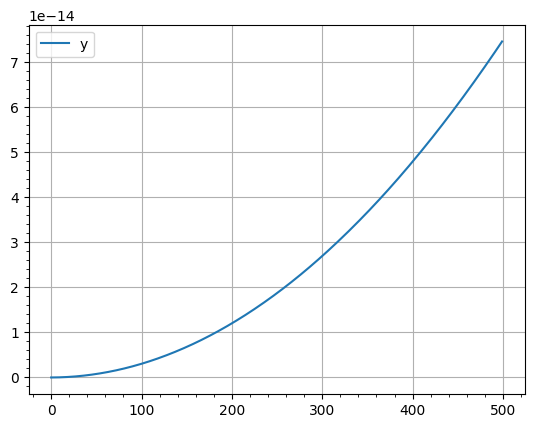

In [75]:

#plotting positions
plt.figure('Leg positions')
#plt.plot(leg_positions_x, label='x')
plt.plot(leg_positions_y, label='y')
#plt.plot(leg_position_z, label='z')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.ylim(-0.0025,0.0025)
#plt.xlim(90, 110)
plt.show()

In [76]:
leg_position_z[0]-leg_position_z[-1]

7.242651721661719e-05

### See where force is applied

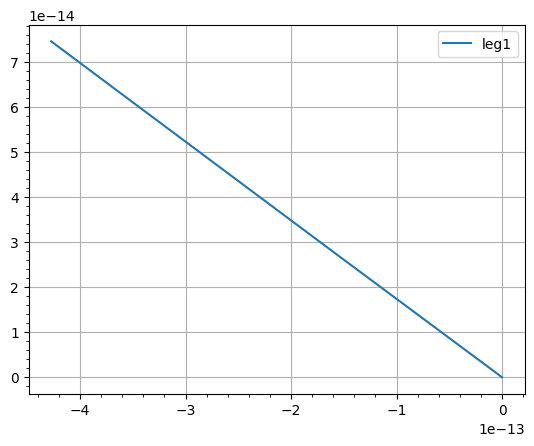

In [77]:
plt.figure('xy motion')
plt.plot(leg_positions_x, leg_positions_y, label = 'leg1')
plt.legend()
#plt.xlim(0,6e-6)
plt.grid()
plt.minorticks_on()
plt.show()

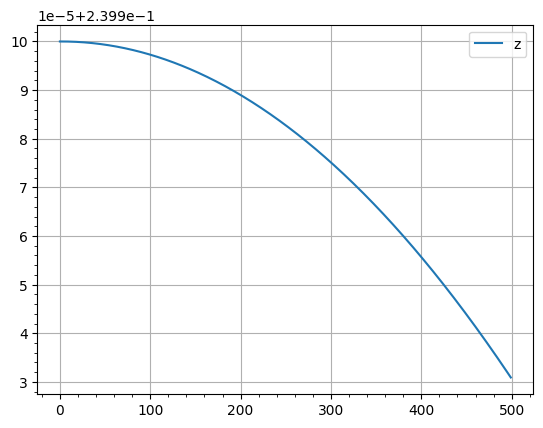

In [78]:
plt.figure()
#plt.plot(joint_positions_x, label = 'x')
#plt.plot(joint_positions_y, label = 'y')
plt.plot(joint_position_z, label = 'z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

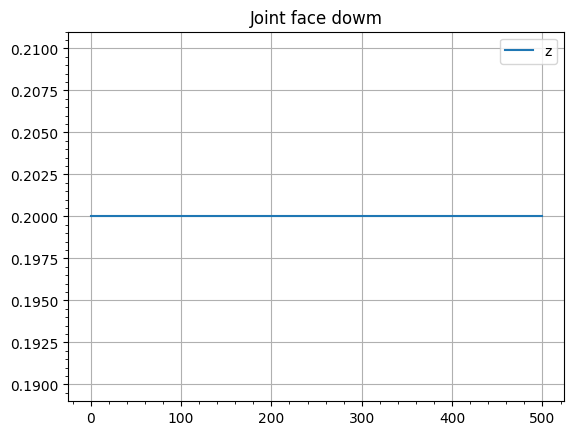

In [79]:
plt.figure()
plt.title("Joint face dowm")
#plt.plot(joint_positions_x, label = 'x')
#plt.plot(joint_positions_y, label = 'y')
plt.plot(joint_positions_down_z, label = 'z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

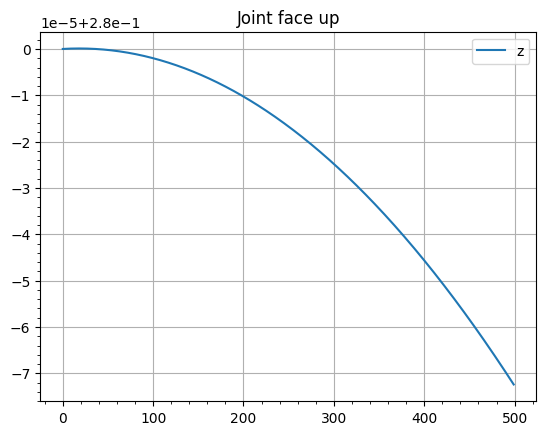

In [80]:
plt.figure()
plt.title("Joint face up")
#plt.plot(joint_positions_x, label = 'x')
#plt.plot(joint_positions_y, label = 'y')
plt.plot(joint_positions_up_z, label = 'z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

In [81]:
joint_position_z[0]-joint_position_z[-1]

6.909019253698023e-05

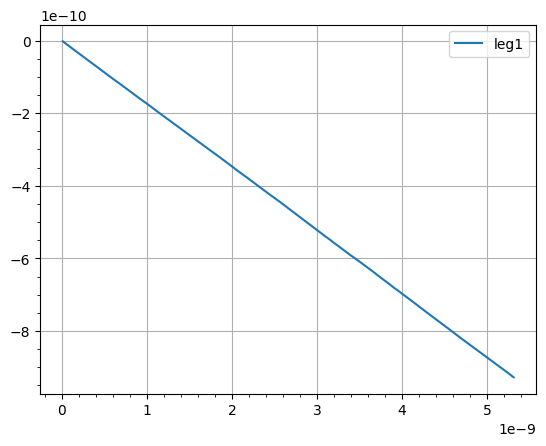

In [82]:
plt.figure('xy motion')
plt.plot(joint_positions_x, joint_positions_y, label = 'leg1')
plt.legend()
#plt.xlim(0,6e-6)
plt.grid()
plt.minorticks_on()
plt.show()

### See tau of exponential decay

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# Supponiamo che leg_positions_x sia un array definito
time = np.arange(len(leg_positions_x[45:-1]))  # Array di tempi in base agli indici
y_data = leg_positions_x[45:-1]  # Dati del segnale (senza valore assoluto)

# Trova i massimi locali usando find_peaks
peaks, _ = find_peaks(y_data)  # Restituisce gli indici dei picchi e altre informazioni

peak_values = []
time_peaks = []
# Estrai i valori dei massimi locali per creare l'inviluppo
for value in peaks:
    peak_values.append(y_data[value])
    time_peaks.append(time[value])

# Definisci la funzione esponenziale da adattare
def exp_decay(t, A, tau):
    return A * np.exp(-t / tau)

# Esegui il fit esponenziale sui massimi
params, covariance = curve_fit(exp_decay, time_peaks, peak_values, p0=(peak_values[0], 100))

# Estrai il parametro tau
A_fit, tau_fit = params
print(f"Stima di tau: {tau_fit}")

# Visualizza i risultati
plt.figure(figsize=(10, 6))
plt.plot(time, y_data, 'b-', label='Dati originali')
plt.plot(time[peaks], peak_values, 'go', label='Massimi locali (inviluppo)')
plt.plot(time, exp_decay(time, *params), 'r--', label=f'Fit esponenziale (tau = {tau_fit:.3f})')
plt.xlabel('Tempo')
plt.ylabel('Ampiezza')
plt.legend()
plt.title('Fit esponenziale dell\'inviluppo (massimi locali)')
plt.show()

IndexError: list index out of range